In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv


In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold,train_test_split
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv


In [7]:
import pandas as pd
sample_submission = pd.read_csv("../input/santander-customer-transaction-prediction/sample_submission.csv")
test_df = pd.read_csv("../input/santander-customer-transaction-prediction/test.csv")
train_df = pd.read_csv("../input/santander-customer-transaction-prediction/train.csv")

In [8]:
total = train_df.isnull().sum()
percent = (train_df.isnull().sum())/(train_df.isnull().count())
tt = pd.concat([total,percent],axis = 1,keys = ['total','percent'])
types = []
for col in train_df.columns:
    dtype = str(train_df[col].dtype)
    types.append(dtype)
tt['Types'] = types
np.transpose(tt)
    

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [9]:
total = test_df.isnull().sum()
percent = (test_df.isnull().sum()/test_df.isnull().count())
tt = pd.concat([total,percent],axis = 1,keys = ['Total','Percent'])
types = []
for col in test_df.columns:
    dtype = str(test_df[col].dtype)
    types.append(dtype)
tt['Types'] = types
np.transpose(tt)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


<Figure size 432x288 with 0 Axes>

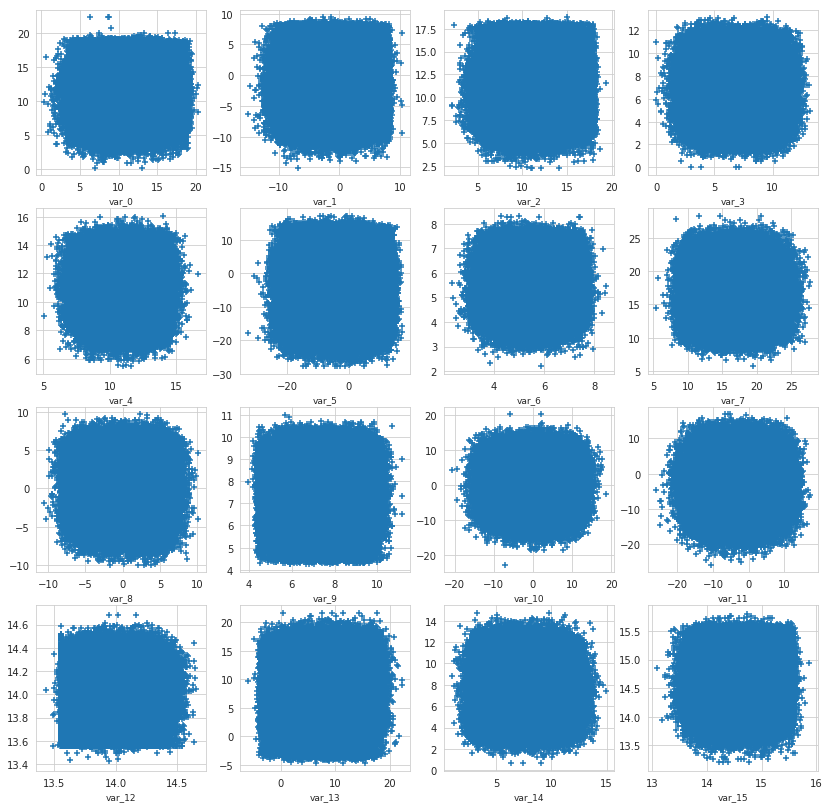

In [10]:
sns.set_style('whitegrid')
plt.figure()
i = 0
features = ['var_0', 'var_1', 'var_2', 'var_3', 'var_4',
            'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 
            'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15',]
fig,ax = plt.subplots(4,4,figsize = (14,14))
for feature in features:
    i = i+1
    plt.subplot(4,4,i)
    plt.scatter(train_df[feature],test_df[feature],marker='+')
    plt.xlabel(feature,fontsize = 9)
plt.show()


<Figure size 432x288 with 0 Axes>

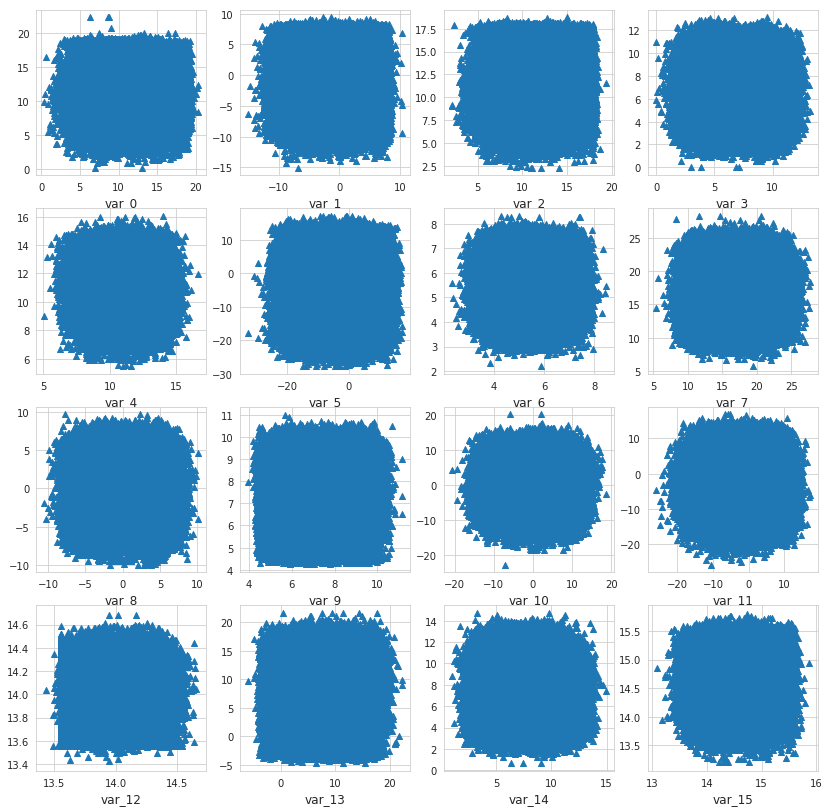

In [11]:
sns.set_style('whitegrid')
features = ['var_0', 'var_1', 'var_2', 'var_3', 'var_4',
            'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 
            'var_10', 'var_11', 'var_12', 'var_13', 'var_14', 'var_15',]
plt.figure()
fig,ax = plt.subplots(4,4,figsize = (14,14))
i = 0
for feature in features:
    i = i+1
    plt.subplot(4,4,i)
    plt.scatter(train_df[feature],test_df[feature],marker='^')
    plt.xlabel(feature,fontsize=12)
    
plt.show()

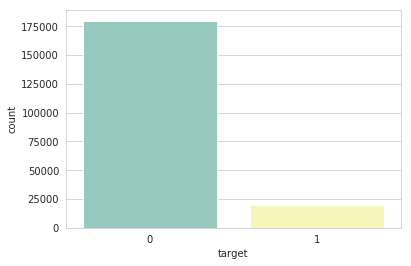

In [12]:
# checking distribution of target value in the training dataset
sns.countplot(train_df['target'],palette='Set3')
plt.show()

In [13]:
train_df['target'].value_counts()[1]/train_df.shape[0] * 100

10.049

In [ ]:
print('There are {}% target variables with 1'.format((train_df['target'].value_counts()[1]/train_df.shape[0]) * 100))

In [ ]:
train_0 = train_df[train_df['target'] == 0]
train_1 = train_df[train_df['target'] == 1]
features = train_df.columns.values[2:102]
sns.set_style('whitegrid')
plt.figure()
i=0
fig,ax = plt.subplots(10,10,figsize = (25,35))
for feature in features:
     i = i + 1
     plt.subplot(10,10,i)
     sns.distplot(train_0[feature],hist=False,label='zero')
     sns.distplot(train_1[feature],hist=False,label='one')
     plt.xlabel(feature)

In [ ]:
train_0 = train_df[train_df['target'] == 0]
train_1 = train_df[train_df['target'] == 1]
features = train_df.columns.values[102:203]
sns.set_style('whitegrid')
i = 0
plt.figure()
fig,ax = plt.subplots(10,10,figsize = (25,22))
for feature in features:
    i = i+1
    plt.subplot(10,10,i)
    sns.distplot(train_0[feature],label='zero')
    sns.distplot(train_1[feature],label='one')
    plt.xlabel(feature)

In [ ]:
features = train_df.columns.values[2:102]
sns.set_style('whitegrid')
plt.figure()
fig,ax = plt.subplots(10,10,figsize = (35,30))
i = 0
for feature in features:
    i = i + 1
    plt.subplot(10,10,i)
    sns.distplot(train_df[feature],label='train')
    sns.distplot(test_df[feature],label='test')
    plt.xlabel(feature)

In [ ]:
features = train_df.columns.values[102:202]
sns.set_style('whitegrid')
plt.figure()
fig,ax = plt.subplots(10,10,figsize = (35,30))
i = 0
for feature in features:
    i = i+1
    plt.subplot(10,10,i)
    sns.distplot(train_df[feature],label='train')
    sns.distplot(test_df[feature],label='test')
    plt.xlabel(feature)

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of mean value per row in training and testing dataset')
sns.distplot(train_df.mean(axis=1),kde=True,color='green',bins=120,label='train')
sns.distplot(test_df.mean(axis=1),kde=True,color='blue',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize = (16,6))
plt.title('Distribution of mean values per columns in train and test set')
sns.distplot(train_df[features].mean(axis=0),label='train',kde=True,bins=120)
sns.distplot(test_df[features].mean(axis=0),label='test',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of standard deviation per row in training and testing dataset')
sns.distplot(train_df.std(axis=1),kde=True,color='black',bins=120,label='train')
sns.distplot(test_df.std(axis=1),kde=True,color='red',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of standard deviation per column in training and testing dataset')
sns.distplot(train_df.std(axis=0),kde=True,color='green',bins=120,label='train')
sns.distplot(test_df.std(axis=0),kde=True,color='red',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of mean value per row in the train set')
sns.distplot(t0[features].mean(axis=1),label='zero',color='red',kde=True,bins=120)
sns.distplot(t1[features].mean(axis=1),label='one',color='blue',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of mean value per column in the train set')
sns.distplot(t0[features].mean(axis=0),label='zero',color='red',kde=True,bins=120)
sns.distplot(t1[features].mean(axis=0),label='one',color='blue',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of min per column training and testing dataset')
sns.distplot(train_df[features].min(axis=0),kde=True,color='green',bins=120,label='train')
sns.distplot(test_df[features].min(axis=0),kde=True,color='red',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of min per row training and testing dataset')
sns.distplot(train_df[features].min(axis=1),kde=True,color='magenta',bins=120,label='train')
sns.distplot(test_df[features].min(axis=1),kde=True,color='darkblue',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of max per row training and testing dataset')
sns.distplot(train_df[features].min(axis=1),kde=True,color='brown',bins=120,label='train')
sns.distplot(test_df[features].min(axis=1),kde=True,color='yellow',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
# lets check the distribution of mean and standard deviation values per row in the train and test dataset
plt.figure(figsize = (16,6))
features = train_df.columns.values[2:202]
plt.title('Distribution of max per column training and testing dataset')
sns.distplot(train_df[features].min(axis=0),kde=True,color='magenta',bins=120,label='train')
sns.distplot(test_df[features].min(axis=0),kde=True,color='yellow',bins=120,label='test')
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of min value per row in the train set')
sns.distplot(t0[features].min(axis=1),label='zero',color='orange',kde=True,bins=120)
sns.distplot(t1[features].min(axis=1),label='one',color='darkblue',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of min value per column in the train set')
sns.distplot(t0[features].min(axis=0),label='zero',color='orange',kde=True,bins=120)
sns.distplot(t1[features].min(axis=0),label='one',color='red',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of max value per row in the train set')
sns.distplot(t0[features].max(axis=1),label='zero',color='brown',kde=True,bins=120)
sns.distplot(t1[features].max(axis=1),label='one',color='yellow',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of max value per column in the train set')
sns.distplot(t0[features].max(axis=0),label='zero',color='brown',kde=True,bins=120)
sns.distplot(t1[features].max(axis=0),label='one',color='yellow',kde=True,bins=120)
plt.legend()
plt.show()

lets check distribution of skewness and kurtosis

In [ ]:
plt.figure(figsize = (16,6))
plt.title('Distribution of skew per row in train and test set')
sns.distplot(train_df[features].skew(axis=1),color='red',kde=True,bins=120,label='train')
sns.distplot(test_df[features].skew(axis=1),color='orange',kde=True,bins=120,label='test')
plt.legend()
plt.show()
# we can observe that the elements in the row are highly skewed towards negative direction

In [ ]:
plt.figure(figsize = (16,6))
plt.title('Distribution of skew per col in train and test set')
sns.distplot(train_df[features].skew(axis=0),color='cyan',kde=True,bins=120,label='train')
sns.distplot(test_df[features].skew(axis=0),color='black',kde=True,bins=120,label='test')
plt.legend()
plt.show()
# data anong columns is highly skewed

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of skew value per column in the train set')
sns.distplot(t0[features].skew(axis=0),label='zero',color='brown',kde=True,bins=120)
sns.distplot(t1[features].skew(axis=0),label='one',color='yellow',kde=True,bins=120)
plt.legend()
plt.show()

In [ ]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize = (16,6))
plt.title('Distribution of skew value per row in the train set')
sns.distplot(t0[features].skew(axis=1),label='zero',color='brown',kde=True,bins=120)
sns.distplot(t1[features].skew(axis=1),label='one',color='yellow',kde=True,bins=120)
plt.legend()
plt.show()

feature correlations between features in the training set

In [14]:
train_df[features].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
# this are the correlated features arranged in asciending order with leart important faetures at the top


,level_0,level_1,0
0,var_1,var_3,0.000010
1,var_3,var_1,0.000010
2,var_15,var_0,0.000043
3,var_0,var_15,0.000043
4,var_6,var_4,0.000049
...,...,...,...
251,var_3,var_3,1.000000
252,var_2,var_2,1.000000
253,var_1,var_1,1.000000
254,var_14,var_14,1.000000


In [15]:
#ten most worstly corelated features
correlations = train_df[features].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]


In [16]:
#ten most worstly corelated features
correlations.head(10)

,level_0,level_1,0
0,var_1,var_3,0.000010
1,var_3,var_1,0.000010
2,var_15,var_0,0.000043
3,var_0,var_15,0.000043
4,var_6,var_4,0.000049
5,var_4,var_6,0.000049
6,var_13,var_15,0.000109
7,var_15,var_13,0.000109
8,var_13,var_9,0.000119
9,var_9,var_13,0.000119


In [17]:
# ten most highly correlated features
correlations.tail(10)

,level_0,level_1,0
230,var_3,var_13,0.005717
231,var_13,var_3,0.005717
232,var_9,var_15,0.006054
233,var_15,var_9,0.006054
234,var_2,var_0,0.006573
235,var_0,var_2,0.006573
236,var_0,var_6,0.006983
237,var_6,var_0,0.006983
238,var_13,var_2,0.008795
239,var_2,var_13,0.008795


In [18]:
# lets check how many duplicate values exist per column
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values_train = train_df[feature].value_counts()
    unique_max_train.append([feature,values_train.max(),values_train.idxmax()]) # the feature max value repeated how many times and
    #the maximum value in the train set
    values_test = test_df[feature].value_counts()
    unique_max_test.append([feature,values_test.max(),values_train.idxmax()])# the feature max value,max value in the feature rep
    #eated how many times,maximum value
#the above values we are inserting tn the arrays are maximum duplicate values
#because pandas values count function gives us how many same values exists
#this are the
np.transpose(pd.DataFrame(unique_max_train,columns = ['features','max_duplicates','value']).sort_values(by = 'max_duplicates',ascending = False))

,68,108,126,12,91,103,148,71,161,25,...,70,74,90,96,120,199,61,187,30,136
features,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,...,var_70,var_74,var_90,var_96,var_120,var_199,var_61,var_187,var_30,var_136
max_duplicates,1084,313,305,203,66,61,59,54,52,41,...,7,7,7,7,7,7,6,6,6,6
value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,...,25.4822,25.6287,-15.9328,12.5468,23.1806,1.9261,-7.6718,-2.9079,-13.3689,16.1478


In [19]:
np.transpose(pd.DataFrame(unique_max_test,columns = ['features','max_feature_values','value']).sort_values(by = 'max_feature_values',ascending = False))

,68,126,108,12,91,103,148,161,25,71,...,70,120,176,61,187,102,74,136,45,54
features,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,...,var_70,var_120,var_176,var_61,var_187,var_102,var_74,var_136,var_45,var_54
max_feature_values,1104,307,302,188,86,78,74,69,60,60,...,14,14,14,14,14,14,13,13,13,13
value,5.0214,11.5356,14.1999,13.5545,6.9785,1.6662,4.0456,5.7688,13.6723,0.7031,...,25.4822,23.1806,2.3942,-7.6718,-2.9079,17.523,25.6287,16.1478,-2.841,-3.6322


In [20]:
#we can observe that same columns in the train and test set have have same or very colse number of duplicates of same or very close values which can 
#be used in the future for classification

In [21]:
idx = features = train_df.columns.values[2:202]
train_df['sum'] = train_df[idx].sum(axis=1)
train_df['min'] = train_df[idx].min(axis=1)
train_df['max'] = train_df[idx].max(axis=1)
train_df['mean'] = train_df[idx].mean(axis=1)
train_df['std'] = train_df[idx].std(axis=1)
train_df['skew'] = train_df[idx].skew(axis=1)
train_df['kurt'] = train_df[idx].kurt(axis=1)
train_df['med'] = train_df[idx].median(axis=1)


In [22]:
train_df.iloc[:,202:]

,sum,min,max,mean,std,skew,kurt,med
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735
...,...,...,...,...,...,...,...,...
199995,1349.0825,-23.6064,35.4923,6.745412,9.568606,-0.048360,0.815615,6.41060
199996,1350.6997,-39.6406,38.8105,6.753499,10.308092,-0.553757,2.620481,6.57875
199997,1374.9384,-49.5007,43.0307,6.874692,9.821335,-0.750798,5.837304,6.40910
199998,1388.1757,-42.9704,46.4915,6.940879,10.989741,-0.175745,3.526916,6.69070


In [23]:
idx = features = test_df.columns.values[1:201]
test_df['sum'] = test_df[idx].sum(axis=1)
test_df['min'] = test_df[idx].min(axis=1)
test_df['max'] = test_df[idx].max(axis=1)
test_df['mean'] = test_df[idx].mean(axis=1)
test_df['std'] = test_df[idx].std(axis=1)
test_df['skew'] = test_df[idx].skew(axis=1)
test_df['kurt'] = test_df[idx].kurt(axis=1)
test_df['med'] = test_df[idx].median(axis=1)


In [24]:
test_df.iloc[:,201:]

,sum,min,max,mean,std,skew,kurt,med
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375
...,...,...,...,...,...,...,...,...
199995,1459.3123,-32.6883,35.3246,7.296562,9.737440,-0.350196,2.124364,6.96660
199996,1282.6610,-48.3446,41.1888,6.413305,10.149715,-0.856927,4.773715,6.39060
199997,1256.8657,-22.2762,45.7036,6.284328,9.672846,-0.041529,1.682290,6.76620
199998,1279.3097,-40.0510,35.0019,6.396549,9.718346,-0.627442,2.886006,6.89120


In [25]:
idx

array(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6',
       'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_12', 'var_13',
       'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19',
       'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_25',
       'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31',
       'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37',
       'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43',
       'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49',
       'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55',
       'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61',
       'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67',
       'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_73',
       'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79',
       'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85',
       'var_86', 'var_87', 'var_88', 'var_89', 'var_

In [ ]:
# for training data
t0 = train_df[train_df['target'] == 0]
t1 = train_df[train_df['target'] == 1]
features = train_df.columns.values[202:]
sns.set_style('whitegrid')
i = 0
plt.figure()
fig,ax = plt.subplots(2,4,figsize = (18,8))
for feature in features:
    i = i+1
    plt.subplot(2,4,i)
    sns.kdeplot(t0[feature],label='zero',bw=0.5)
    sns.kdeplot(t1[feature],label='one',bw=0.5)
    plt.xlabel(feature)
plt.show()

In [ ]:
# new features for training and testing data
# for training data
features = train_df.columns.values[202:]
sns.set_style('whitegrid')
i = 0
plt.figure()
fig,ax = plt.subplots(2,4,figsize = (18,8))
for feature in features:
    i = i+1
    plt.subplot(2,4,i)
    sns.kdeplot(train_df[feature],label='train',bw=0.5)
    sns.kdeplot(test_df[feature],label='test',bw=0.5)
    plt.xlabel(feature)
plt.show()

In [26]:
features = [c for c in train_df.columns.values if c not in ['ID_code','target']]

In [27]:
train_df_2 = pd.DataFrame()
test_df_2 = pd.DataFrame()
train_df_1 = pd.DataFrame()
test_df_1 = pd.DataFrame()

In [28]:
features = [c for c in train_df.columns.values if c not in ['ID_code','target']]
for feature in features:
    train_df_2['r2_',feature] = np.round(train_df[feature],2)
    test_df_2['r2_',feature] = np.round(test_df[feature],2)
    train_df_1['r1_',feature] = np.round(train_df[feature],1)
    test_df_1['r1_',feature] = np.round(test_df[feature],1)

In [29]:
features = [c for c in train_df.columns.values if c not in ['ID_code','target']]
target = train_df['target']

In [ ]:
X_train = train_df[features]
X_test = test_df[features]
y_train = target.values.reshape(-1,1)

In [ ]:
X_train

In [ ]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer()
X_train = qt.fit_transform(X_train)
X_test = qt.fit_transform(X_test)

In [ ]:
plt.figure(figsize = (16,6))
plt.title('Distribution of skew per row in train and test set')
sns.distplot(train_df[features].skew(axis=0),color='blue',kde=True,bins=120,label='train')
sns.distplot(test_df[features].skew(axis=0),color='orange',kde=True,bins=120,label='test')
plt.legend()
plt.show()
# we can observe that the elements in the row are highly skewed towards negative direction

In [ ]:
plt.figure(figsize = (16,6))
plt.title('Distribution of skew per row in train and test set')
sns.distplot(pd.DataFrame(X_train).skew(axis=0),color='blue',kde=True,bins=120,label='train')
sns.distplot(pd.DataFrame(X_train).skew(axis=0),color='red',kde=True,bins=120,label='test')
plt.legend()
plt.show()
# we can observe that the elements in the row are highly skewed towards negative direction

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import roc_curve,auc
X_proba = clf.predict_proba(X_train)[:,1]
fpr,tpr,thr = roc_curve(y_train,X_proba)
plt.plot(fpr,tpr)

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf,X_train,y_train,cv=10,scoring = 'roc_auc').mean()

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf,X_train,y_train,cv=10,scoring = 'accuracy').mean()

In [ ]:
y_pred = clf.predict(X_test)

In [1]:
y_pred


NameError: name 'y_pred' is not defined

In [35]:
X = train_df[features].values
y = train_df['target'].values.reshape(-1,1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
X = pt.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
clf = RandomForestClassifier(n_estimators = 100,criterion='entropy',random_state=0)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
y_test_hat_probs = clf.predict_proba(X_test)[:,1]
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
print(classification_report(y_test,y_pred))
print('roc_auc_score',roc_auc_score(y_test,y_test_hat_probs))

In [ ]:
# lets do some hyper parameter tuning in this tree
from sklearn.model_selection import RandomizedSearchCV
#number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100,stop=2000,num=10)]
#number of reatures to be considered at every split
max_features = ['auto','sqrt']
#max number of levels in the tree
max_depth = [int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
#min number of samples required to split the node
min_sample_split = [2,5,10]
#min number of samples required at each leaf node
min_sample_leaf = [1,2,4]
#method for selecting sample for training each tree
bootstrap = [True,False]

In [ ]:
random_grid_clf = {'n_estimators':n_estimators,
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_sample_split,
               'min_samples_leaf':min_sample_leaf,
               'bootstrap':bootstrap,
               'criterion':['gini','entropy']
    
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier()
clf_random = RandomizedSearchCV(clf,random_grid_clf,n_iter=100,cv=3,verbose=2,n_jobs=-1)
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
X = pt.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
clf_random.fit(X_train,y_train)

In [ ]:
clf_random.best_params_

In [ ]:
best_random_forest_classifier = clf_random.best_estimators_
best_random_forest_classifier.fit(X_train,y_train)
y_pred = best_random_forest_classifier.predict(X_test)
classification_report(y_test,y_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid_clf = {
    'bootstrap':[True],
    'max_depth':max_depth,
    'max_features':['auto','sqrt'],
    'min_samples_split':[2,3,8,11,5],
    'min_samples_leaf':[3,4,5],
    'n_estimators':[100,200,300,400,1000],
    'criterion':['gini','entropy']
    
}

In [ ]:
grid_search_clf = GridSearchCV(clf,param_grid_clf,cv=6,n_jobs=-1,verbose=2)

grid_search_clf.fit(X_train,y_train)
grid_search_clf.best_params_


In [ ]:
best_random_forest_classifier_gs = grid_search_clf.best_estimators_
best_random_forest_classifier_gs.fit(X_train,y_train)
y_pred = best_random_forest_classifier_gs.predict(X_test)
classification_report(y_test,y_pred)